In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pandas ayarları 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [ ]:
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.csv"

df = pd.read_csv(url, parse_dates=["time"])#burda dataframe oluştururken time sütununu datetime formatına çevirdik
#normalde pd.DataFrame() ile de oluşturabilirdik ama burda kendi verimizi değil de url üzerinden çektiğimiz veriyi dataframe yapısına çevirdik

print(f"veri çekildi,toplam {df.shape[0]} satır var {df.shape[1]} sütun var")

veri çekildi,toplam 1894 satır var 22 sütun var


In [6]:
df.head()#verilerimizin ilk 5 satırını gösterelim dataframe yapısında head

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2026-02-07 16:43:03.070000+00:00,62.906000,-148.823000,61.900000,2.30,ml,52,56,0.10000,0.90,ak,ak2026crfcxn,2026-02-07T16:45:15.098Z,"54 km S of Cantwell, Alaska",earthquake,2.80,2.7486,0.400000,12,automatic,ak,ak
1,2026-02-07 16:40:19.440000+00:00,33.709000,-117.062667,11.050000,0.75,ml,15,194,0.05098,0.11,ci,ci41393544,2026-02-07T16:43:53.922Z,"2 km E of Winchester, CA",earthquake,1.12,0.6500,0.189432,18,automatic,ci,ci
2,2026-02-07 16:15:23.930000+00:00,19.070667,-155.351501,32.520000,1.71,md,28,260,0.13430,0.16,hv,hv74896087,2026-02-07T16:18:55.420Z,"19 km SE of Pāhala, Hawaii",earthquake,0.77,0.8300,0.092083,16,automatic,hv,hv
3,2026-02-07 16:07:53.170000+00:00,33.509167,-116.547500,13.150000,0.59,ml,31,50,0.04793,0.15,ci,ci41393528,2026-02-07T16:11:28.894Z,"13 km ESE of Anza, CA",earthquake,0.20,0.4000,0.171724,16,automatic,ci,ci
4,2026-02-07 16:06:48.390000+00:00,19.065166,-155.377335,32.470001,1.90,md,42,205,0.12040,0.23,hv,hv74896077,2026-02-07T16:10:55.330Z,"18 km SE of Pāhala, Hawaii",earthquake,0.84,0.8700,0.152687,16,automatic,hv,hv


In [7]:
#eksik veriler var mı bakalım
df.isnull().sum()

time                0
latitude            0
longitude           0
depth               0
mag                 0
magType             0
nst                 0
gap                 0
dmin               17
rms                 0
net                 0
id                  0
updated             0
place               0
type                0
horizontalError    57
depthError         10
magError           10
magNst              0
status              0
locationSource      0
magSource           0
dtype: int64

In [10]:
#fillna ile eksik verileri doldururuz pandasta

# 1. 'dmin' (En yakın istasyona uzaklık) sütununu ORTALAMA ile dolduralım

dmin_mean=df['dmin'].mean()
df['dmin'] = df['dmin'].fillna(dmin_mean)#dataframde ilgili sütunu seçip fillna ile atama yaptık

# 2. 'horizontalError' (Yatay Hata) sütununu MEDYAN ile dolduralım

error_median = df['horizontalError'].median()
df['horizontalError'] = df['horizontalError'].fillna(error_median)

# 3. Diğer eksikleri (depthError, magError) 0 ile dolduralım
# Bazen eksik hata verisi "Hata yok" veya "Ölçülemedi" anlamına gelir.

df['depthError'] = df['depthError'].fillna(0)
df['magError'] = df['magError'].fillna(0)

print(f"Toplam Boş Veri Sayısı: {df.isnull().sum().sum()}")


Toplam Boş Veri Sayısı: 0


In [11]:
df.isnull().sum()

time               0
latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                0
gap                0
dmin               0
rms                0
net                0
id                 0
updated            0
place              0
type               0
horizontalError    0
depthError         0
magError           0
magNst             0
status             0
locationSource     0
magSource          0
dtype: int64

In [15]:
# 1. ENERJİ HESAPLAMA (Vektörizasyon)
# yeni birkaç sütun eklemesi yapacağız 
# Formül: Enerji = 10^(1.5 * Büyüklük + 4.8)
# (for loop) kullanmak yerine NumPy kullanıyoruz. çünkü NumPy, büyük veri setlerinde döngülere göre çok daha hızlıdır.
df['Energy_Joule'] = np.power(10, (1.5 * df['mag'] + 4.8))#yeni sütun böyle oluşturulurdu sonra atama yaparak dataframe'e ekledik

df['Risk_Durumu'] = np.where(df['mag'] > 5.0, 'Tehlikeli', 'Düşük Risk')

# Sadece ilgili sütunları seçip (filter) ilk 5 satıra bakalım.
print(df[['place', 'mag', 'Energy_Joule', 'Risk_Durumu']].head())

                         place   mag  Energy_Joule Risk_Durumu
0  54 km S of Cantwell, Alaska  2.30  1.778279e+08  Düşük Risk
1     2 km E of Winchester, CA  0.75  8.413951e+05  Düşük Risk
2   19 km SE of Pāhala, Hawaii  1.71  2.317395e+07  Düşük Risk
3        13 km ESE of Anza, CA  0.59  4.841724e+05  Düşük Risk
4   18 km SE of Pāhala, Hawaii  1.90  4.466836e+07  Düşük Risk


In [ ]:
# 1. Koşul: Yeri (place) sütununda "Turkey" yazanları bul (Büyük/küçük harf duyarsız)
kosul = df['place'].str.contains("Turkey", case=False)

# 2. Seçim: Bu koşula uyanların sadece Tarih, Yer, Büyüklük ve Derinliğini getir
#loc location demektir df.loc(kosul,sütunlar) şeklinde kullanılır
turkiye_depremleri = df.loc[kosul, ['time', 'place', 'mag', 'depth']]

print(f"Son 7 günde Türkiye ve çevresinde {len(turkiye_depremleri)} deprem oldu.")
print(turkiye_depremleri)

Son 7 günde Türkiye ve çevresinde 1 deprem oldu.
                                time                        place  mag  depth
281 2026-02-06 11:16:16.595000+00:00  20 km S of Refahiye, Turkey  4.8   10.0


In [18]:
#gruplama ve analiz adımı (groupby)
#EN ÇOK DEPREM OLAN 5 YER (Frekans Sayma)

print("Dünyada En Çok Deprem Olan 5 Bölge")
print(df['place'].value_counts().head(5))

#BÖLGELERE GÖRE ORTALAMA BÜYÜKLÜK (Aggregation)
#Yere göre grupla, büyüklüklerin ortalamasını al.
bolgesel_analiz = df.groupby('place')['mag'].mean()

#Ortalaması (en şiddetli) 5 yeri görelim
print("\nOrtalama Şiddeti En Yüksek 5 Bölge")
print(bolgesel_analiz.sort_values(ascending=False).head(5))

ozet_tablo = df.groupby('status')['mag'].agg(['count', 'mean', 'max'])

print("\nDeprem Durumuna Göre Özet")
print(ozet_tablo)

Dünyada En Çok Deprem Olan 5 Bölge
place
4 km ESE of San Ramon, CA     41
8 km NW of The Geysers, CA    29
4 km SE of San Ramon, CA      26
5 km SE of San Ramon, CA      21
7 km NW of The Geysers, CA    20
Name: count, dtype: int64

Ortalama Şiddeti En Yüksek 5 Bölge
place
Kermadec Islands, New Zealand              6.1
Pulau Pulau Tanimbar, Indonesia            5.9
92 km ENE of ‘Ohonua, Tonga                5.8
94 km SW of Trenggalek, Indonesia          5.8
97 km W of Yenangyaung, Burma (Myanmar)    5.8
Name: mag, dtype: float64

Deprem Durumuna Göre Özet
           count      mean  max
status                         
automatic    602  1.443815  3.5
reviewed    1292  1.783599  6.1


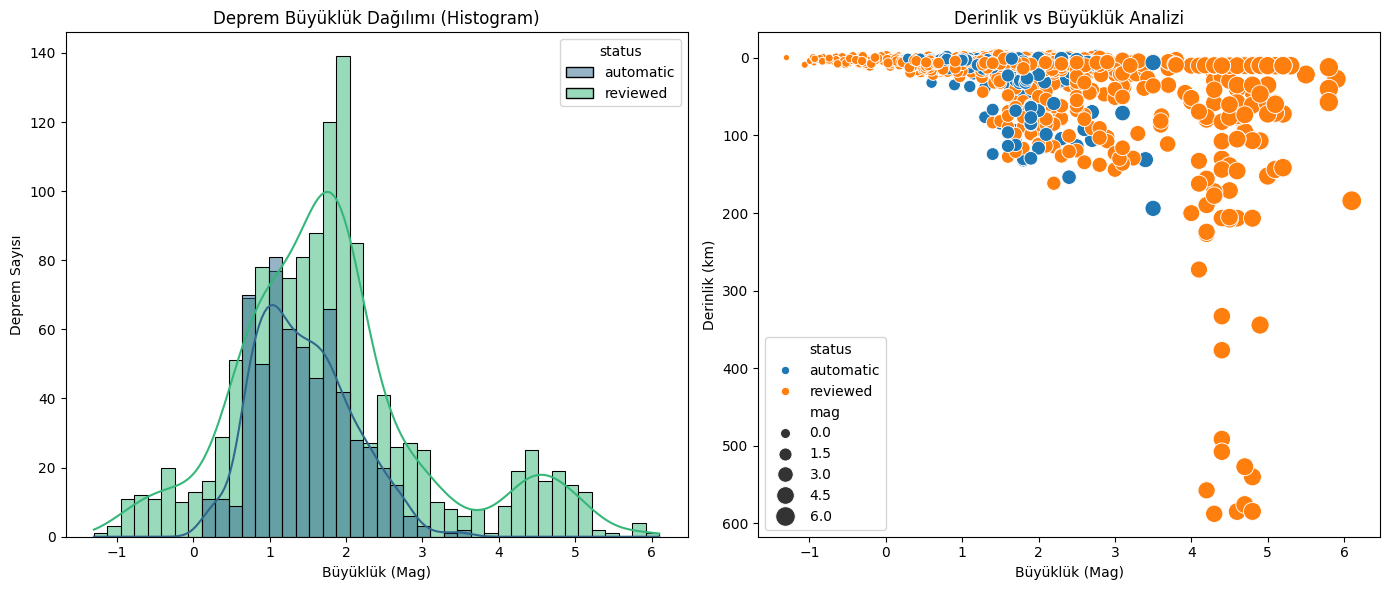

In [19]:
# GÖRSELLEŞTİRME

plt.figure(figsize=(14, 6))

#GRAFİK 1: HİSTOGRAM

plt.subplot(1, 2, 1)

# sns.histplot: Seaborn'un histogram fonksiyonu.
# data=df: Veri kaynağımız.
# x='mag': X eksenine 'mag' (büyüklük) koy.
# kde=True: Üzerine o yumuşak dağılım çizgisini (Kernel Density Estimate) çek.
# hue='status': Çubukları 'status' (otomatik/incelenmiş) durumuna göre renklendir.
sns.histplot(data=df, x='mag', kde=True, hue='status', palette='viridis')

plt.title('Deprem Büyüklük Dağılımı (Histogram)')
plt.xlabel('Büyüklük (Mag)')
plt.ylabel('Deprem Sayısı')


#GRAFİK 2: SCATTER PLOT

plt.subplot(1, 2, 2)

sns.scatterplot(data=df, x='mag', y='depth', hue='status', size='mag', sizes=(20, 200))

plt.title('Derinlik vs Büyüklük Analizi')
plt.xlabel('Büyüklük (Mag)')
plt.ylabel('Derinlik (km)')

# ÖNEMLİ DETAY: Derinlik grafiğinde Y eksenini ters çeviririz.
# Çünkü yerin altı (derinlik arttıkça) aşağı doğru gider.
plt.gca().invert_yaxis() 

# Grafikleri göster
plt.tight_layout()
plt.show()

In [20]:
#VERİYİ KAYDETME

# Temizlenmiş veriyi CSV olarak kaydediyoruz.
# index=False: Pandas'ın en başa koyduğu 0,1,2... numaralarını dosyaya yazma demek.
df.to_csv('deprem_analizi_cleaned.csv', index=False)

print("Dosya başarıyla kaydedildi")


Dosya başarıyla kaydedildi
